In [1]:
import numpy as np
import qctrlopencontrols as qoc
import qctrlvisualizer as qv
import qutip as qt

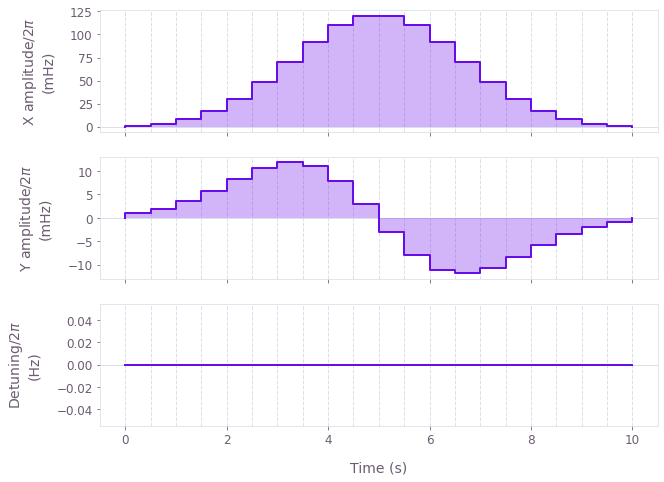

In [2]:
dimension = 3
detuning = 0.0
anharmonicity = -0.3

omega = 2 * np.pi * detuning
alpha = 2 * np.pi * anharmonicity

duration = 10
sampling_period = 0.5
segment_count = int(duration / sampling_period)

drag = qoc.new_drag_control(
    rabi_rotation=np.pi,
    segment_count=segment_count,
    duration=duration,
    width=duration / 6,
    beta=-0.5 / alpha,
    azimuthal_angle=0,
    name="Half-DRAG X-pi",
)

drag_control = drag.export(
    coordinates="cartesian",
    dimensionless_rabi_rate=False,
)

qv.plot_controls(drag_control)

In [3]:
drag_control

{'X amplitude': [{'value': 0.0047393779720006305, 'duration': 0.5},
  {'value': 0.02139198645359087, 'duration': 0.5},
  {'value': 0.05302184966239403, 'duration': 0.5},
  {'value': 0.10710626190788608, 'duration': 0.5},
  {'value': 0.18995634966507266, 'duration': 0.5},
  {'value': 0.3028012082168498, 'duration': 0.5},
  {'value': 0.4377426963904773, 'duration': 0.5},
  {'value': 0.576094628011594, 'duration': 0.5},
  {'value': 0.691407555184394, 'duration': 0.5},
  {'value': 0.7573307401255337, 'duration': 0.5},
  {'value': 0.7573307401255337, 'duration': 0.5},
  {'value': 0.691407555184394, 'duration': 0.5},
  {'value': 0.576094628011594, 'duration': 0.5},
  {'value': 0.4377426963904773, 'duration': 0.5},
  {'value': 0.3028012082168498, 'duration': 0.5},
  {'value': 0.18995634966507266, 'duration': 0.5},
  {'value': 0.10710626190788608, 'duration': 0.5},
  {'value': 0.05302184966239403, 'duration': 0.5},
  {'value': 0.02139198645359087, 'duration': 0.5},
  {'value': 0.00473937797200

In [4]:
x = drag_control["X amplitude"]
y = drag_control["Y amplitude"]

pwc = [
    {
        "value": x["value"] + 1j * y["value"],
        "duration": x["duration"],
    }
    for x, y in zip(x, y)
]
pwc

[{'value': (0.0047393779720006305+0.006052916723845559j), 'duration': 0.5},
 {'value': (0.02139198645359087+0.012174147230828438j), 'duration': 0.5},
 {'value': (0.05302184966239403+0.02206850504319023j), 'duration': 0.5},
 {'value': (0.10710626190788608+0.03591125073262349j), 'duration': 0.5},
 {'value': (0.18995634966507266+0.05214334458115787j), 'duration': 0.5},
 {'value': (0.3028012082168498+0.06690848948087126j), 'duration': 0.5},
 {'value': (0.4377426963904773+0.07459037137745968j), 'duration': 0.5},
 {'value': (0.576094628011594+0.06979338205104493j), 'duration': 0.5},
 {'value': (0.691407555184394+0.05013470929350305j), 'duration': 0.5},
 {'value': (0.7573307401255337+0.01828536987666255j), 'duration': 0.5},
 {'value': (0.7573307401255337-0.01828536987666255j), 'duration': 0.5},
 {'value': (0.691407555184394-0.05013470929350305j), 'duration': 0.5},
 {'value': (0.576094628011594-0.06979338205104493j), 'duration': 0.5},
 {'value': (0.4377426963904773-0.07459037137745968j), 'dura

In [5]:
sum = 0
for seg in pwc:
    sum += seg["value"].real * seg["duration"]
sum

3.141592653589793

In [6]:
a = qt.destroy(dimension)
ad = a.dag()

H_sys = omega * ad * a + 0.5 * alpha * ad * ad * a * a


def propagator(value: complex, duration: float):
    H_ctrl = 0.5 * ad * value + 0.5 * a * np.conj(value)
    H = H_sys + H_ctrl
    # U = qt.propagator(H, duration)
    U = (-1j * H * duration).expm()
    return U


unitaries = [qt.qeye(dimension)]
for seg in pwc:
    U = propagator(seg["value"], seg["duration"]) * unitaries[-1]
    unitaries.append(U)

In [7]:
unitaries[-1]

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[ 0.01675139-0.01039385j -0.22193492-0.97480154j  0.00516104-0.00956985j]
 [-0.22193492-0.97480154j  0.01966257+0.00201861j -0.0103329 +0.00306586j]
 [ 0.00516104-0.00956985j -0.0103329 +0.00306586j  0.90133328+0.43285555j]]

In [8]:
initial_state = qt.basis(dimension, 0)

In [9]:
states = [U * initial_state for U in unitaries]

In [10]:
states[-1]

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.01675139-0.01039385j]
 [-0.22193492-0.97480154j]
 [ 0.00516104-0.00956985j]]

In [11]:
times = np.arange(0, duration + sampling_period, sampling_period)
times

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

In [12]:
def display_bloch_sphere(states):
    states = np.array(states).squeeze()
    qv.display_bloch_sphere(states[:, :2])


def plot_populations(times, states):
    states = np.array(states).squeeze()
    populations = np.abs(states) ** 2
    qv.plot_population_dynamics(
        sample_times=times,
        populations={rf"$|{k}\rangle$": populations[:, k] for k in range(dimension)},
    )


def print_final_populations(states):
    states = np.array(states).squeeze()
    populations = np.abs(states[-1]) ** 2
    for k in range(dimension):
        print(f"|{k}> : {populations[k]:>6.2%}")

|0> :  0.04%
|1> : 99.95%
|2> :  0.01%


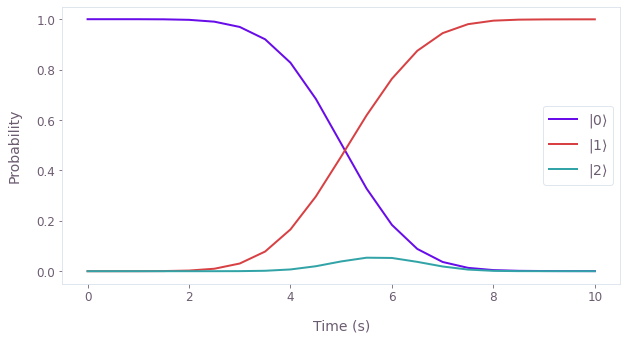

In [13]:
print_final_populations(states)
plot_populations(times, states)

In [14]:
display_bloch_sphere(states)

<IPython.core.display.Javascript object>